# Figure 03

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37671/status,
Dashboard: /proxy/37671/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43305,Workers: 6
Dashboard: /proxy/37671/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:43161,Total threads: 3
Dashboard: /proxy/43539/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:45611,


### Read in Data

In [3]:
# Open initial particle parameters file
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile, decode_cf=False).load()
i = 1
refsub = ref.isel(trajectory = slice(i*130146, (i+1)*130146))

Read in dataset example.

In [4]:
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/xarray_files/traj_chunked_basin/'
files = sorted(glob(datadir+'CircumAntarcticParticles_*.nc')) 
ds = xr.open_dataset(files[i]).drop_vars(['psal','thermo','mixedlayershuffle',
                                          'mldepth', 'unbeachCount', 'z', 
                                          'basin','basin_ZonalConn']).load()

### Define plotting libraries, functions, etc. 

Import plotting libraries. 

In [7]:
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] )
print(module_path)

if module_path not in sys.path:
    sys.path.append(module_path)
    
import custom_functions as cf

/home/561/hd4873/parcel_runs


In [8]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

# cartopy libraries
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Define functions and plotting data.  

In [10]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yu_ocean = hu.yu_ocean.values
yu_ocean[0] = -90
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

Ncontour = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/input/proj01/sea_level_contour_ryf9091_N_cutoff.nc')
basin_mask = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')
basin_mask['basins'] = basin_mask.basins.where(basin_mask.basins != 100, np.nan)

def stereo_plot(axes, extent):
    '''
    Return Antarctic stereographic plot on axes
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_extent(extent, crs=ccrs.PlateCarree())
    axes.set_boundary(circle, transform=axes.transAxes)
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=2,
                 colors='lightgrey', alpha=1, linewidths=1, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=4,
                 colors='darkgrey', alpha=0.9, linewidths=0.8, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1.5, zorder=3, transform = ccrs.PlateCarree())
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.8, color='beige', alpha=1, linestyle=':')
    gl.ylocator = mticker.FixedLocator([-80, -70, -60])

    return 


def mercator_plot(axes, extent, xticks, yticks):
    '''
    Return Antarctic Mercator plot on axes
    '''
    axes.set_extent(extent)
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=2, zorder=3, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=3,
                 colors='dimgrey', alpha=1, linewidths=1, transform = ccrs.PlateCarree())
    axes.set_xticks(xticks, crs=ccrs.PlateCarree())
    axes.set_yticks(yticks, crs=ccrs.PlateCarree())
    axes.xaxis.set_major_formatter(LongitudeFormatter())
    axes.yaxis.set_major_formatter(LatitudeFormatter())
    axes.tick_params(axis='x',labelsize=11)
    axes.tick_params(axis='y',labelsize=11)


def add_basin_txt_stereo(axes, txtcolor, pathcolor):
    '''
    Add basin labels to stero plot
    txtcolor: string describing color of text labels
    pathcolor: string describing color of background border text
    '''
    fw = 'bold'
    fs = 18
    txt = axes.text(65, -66, 'East \nAntarctica \n- West', horizontalalignment='left', 
            color= txtcolor, fontweight=fw, fontsize=fs,
                transform=ccrs.PlateCarree())
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground= pathcolor)])
    txt = axes.text(136, -60, 'East \nAntarctica \n- East', horizontalalignment='left', 
                color= txtcolor, fontweight=fw, fontsize=fs,
                transform=ccrs.PlateCarree())
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground= pathcolor)])
    txt = axes.text(200, -63, 'Ross \nSea', horizontalalignment='left', 
                color= txtcolor, fontweight=fw, fontsize=fs,zorder=5,
                transform=ccrs.PlateCarree())
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground=pathcolor)])
    txt = axes.text(-99, -69, 'West \nAntarctica', horizontalalignment='right', 
                color= txtcolor, fontweight=fw, fontsize=fs,
                transform=ccrs.PlateCarree())
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground= pathcolor)])
    txt = axes.text(-72, -51, 'Antarctic \nPenin-\nsula', horizontalalignment='left', 
                color= txtcolor, fontweight=fw, fontsize=fs,zorder=5,
                transform=ccrs.PlateCarree())
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground= pathcolor)])
    txt = axes.text(-38, -61, 'Weddell \nSea', horizontalalignment='left', 
                color= txtcolor, fontweight=fw, fontsize=fs,
                transform=ccrs.PlateCarree())
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground= pathcolor)])
    
    
def add_lonlabels_stereo_panela(axes, txtcolor, Nbound):
    '''
    Add longitude labels to stero plot
    txtcolor: string describing color of text labels
    Nbound: integer value for northern boundary of stereo plot
    '''
    fs=18
    txt = axes.text(-2, Nbound -0.5 , u'0\u00B0E', horizontalalignment='left', 
                color= txtcolor, fontweight='normal', fontsize=fs,
                    transform=ccrs.PlateCarree())
    txt = axes.text(61, Nbound-2, u'60\u00B0E', horizontalalignment='left', 
                color= txtcolor, fontweight='normal', fontsize=fs,
                rotation=-60, transform=ccrs.PlateCarree())
    txt = axes.text(124, Nbound-1, u'120\u00B0E', horizontalalignment='left', 
                color= txtcolor, fontweight='normal', fontsize=fs,
                rotation=60, transform=ccrs.PlateCarree())
    txt = axes.text(183, Nbound, u'180\u00B0E', horizontalalignment='left', 
                color= txtcolor, fontweight='normal', fontsize=fs,
                    transform=ccrs.PlateCarree())
    txt = axes.text(-124, Nbound, u'120\u00B0W', horizontalalignment='right', 
                color= txtcolor, fontweight='normal', fontsize=fs,
                rotation=-60, transform=ccrs.PlateCarree())
    txt = axes.text(-60, Nbound-2, u'60\u00B0W', horizontalalignment='right', 
                color= txtcolor, fontweight='normal', fontsize=fs,
                rotation=60, transform=ccrs.PlateCarree())
    
# Create bathymetry colormap
def truncate_colormap(cmap, minval=0.0, maxval=6000, n=6):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = matplotlib.cm.get_cmap('Greys')
cmap_ht = truncate_colormap(cmap, 0.0, 0.9)
# define the bins and normalize
bounds = np.linspace(0, 6000, 7)
norm_ht = colors.BoundaryNorm(bounds, cmap_ht.N)

## Panel A

Read in trajectory data

In [15]:
%%time
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ds = xr.open_dataset(startfile, decode_cf=False)
traj1 = np.where(ds.lon == 77)[0] 
traj2 = np.where(ds.lon == -163)[0] 
traj3 = np.where(ds.lon == -48)[0]
traj4 = np.where(ds.lon == -88)[0] 
traj5 = np.where(ds.lon == 142-360)[0] 

# find 100 random particle ids from each basin
nparts = 100
traj1_rand = random.sample(list(ds.trajectory[traj1].values), nparts)
traj2_rand = random.sample(list(ds.trajectory[traj2].values), nparts)
traj3_rand = random.sample(list(ds.trajectory[traj3].values), nparts)
traj4_rand = random.sample(list(ds.trajectory[traj4].values), nparts)
traj5_rand = random.sample(list(ds.trajectory[traj5].values), nparts)

# load particle data
def preprocess(ds):
    return ds.drop_vars(['psal','thermo','mixedlayershuffle',
                         'mldepth', 'unbeachCount', 'z', 'shelf',
                         'basin','basin_ZonalConn'])

datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/xarray_files/traj_chunked_basin/'
files = sorted(glob(datadir+'CircumAntarcticParticles_*.nc')) 
particles1 = xr.open_mfdataset(files, preprocess=preprocess, parallel = True).sel(trajectory = traj1_rand).load()
particles2 = xr.open_mfdataset(files, preprocess=preprocess, parallel = True).sel(trajectory = traj2_rand).load()
particles3 = xr.open_mfdataset(files, preprocess=preprocess, parallel = True).sel(trajectory = traj3_rand).load()
particles4 = xr.open_mfdataset(files, preprocess=preprocess, parallel = True).sel(trajectory = traj4_rand).load()
particles5 = xr.open_mfdataset(files, preprocess=preprocess, parallel = True).sel(trajectory = traj5_rand).load()

print(particles1.nbytes/1000**3)

0.001223304
CPU times: user 32.4 s, sys: 6.36 s, total: 38.8 s
Wall time: 2min 44s


Shift time axis of delayed start particles so they are all aligned at time = 0.

In [16]:
%%time
print("Dataset 1")
for i in range(nparts):
    idx = np.where(np.isnan(particles1.lon[:73,i] ))[0]
    if len(idx)>0:
        idx=idx[-1]+1
        particles1.lon[:,i] = particles1.lon[:,i].shift(time=-idx)
        particles1.lat[:,i] = particles1.lat[:,i].shift(time=-idx)

print("Dataset 2")
for i in range(nparts):
    idx = np.where(np.isnan(particles2.lon[:73,i] ))[0]
    if len(idx)>0:
        idx=idx[-1]+1
        particles2.lon[:,i] = particles2.lon[:,i].shift(time=-idx)
        particles2.lat[:,i] = particles2.lat[:,i].shift(time=-idx)

print("Dataset 3")
for i in range(nparts):
    idx = np.where(np.isnan(particles3.lon[:73,i] ))[0]
    if len(idx)>0:
        idx=idx[-1]+1
        particles3.lon[:,i] = particles3.lon[:,i].shift(time=-idx)
        particles3.lat[:,i] = particles3.lat[:,i].shift(time=-idx)
        
print("Dataset 4")
for i in range(nparts):
    idx = np.where(np.isnan(particles4.lon[:73,i] ))[0]
    if len(idx)>0:
        idx=idx[-1]+1
        particles4.lon[:,i] = particles4.lon[:,i].shift(time=-idx)
        particles4.lat[:,i] = particles4.lat[:,i].shift(time=-idx)
        
print("Dataset 5")
for i in range(nparts):
    idx = np.where(np.isnan(particles5.lon[:73,i] ))[0]
    if len(idx)>0:
        idx=idx[-1]+1
        particles5.lon[:,i] = particles5.lon[:,i].shift(time=-idx)
        particles5.lat[:,i] = particles5.lat[:,i].shift(time=-idx)
        
# Wrap particles 5 dataset
particles5['lon'] = particles5.lon.where(particles5.lon >= -30, particles5.lon + 360)
particles1['lon'] = particles1.lon.where(particles1.lon >-100, particles1.lon + 360)

Dataset 1
Dataset 2
Dataset 3
Dataset 4
Dataset 5
CPU times: user 995 ms, sys: 120 ms, total: 1.12 s
Wall time: 1.02 s


Read in bathymetry and define colormap

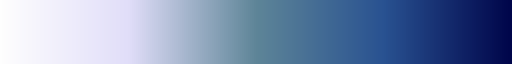

In [48]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yu_ocean = hu.yu_ocean.values
yu_ocean[0] = -90
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

norm=plt.Normalize(0,6000)
cmap_bathblue = colors.LinearSegmentedColormap.from_list("", ["#FEFEFE","#E1DEF9", "#5E8598","#295291","#00054A"])
cmap_bathblue

Plot figure. 

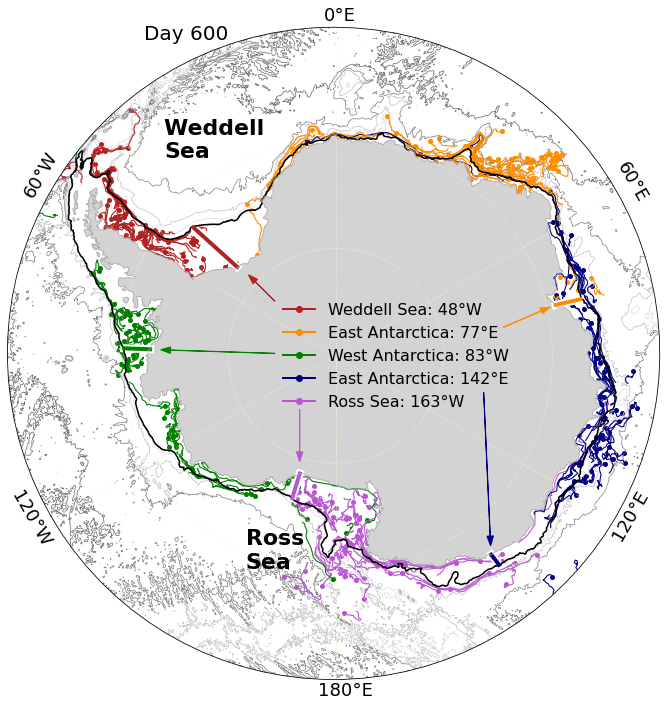

In [20]:
#background = 'speed'
#background = 'shadedbathymetry'
background = 'contourbathymetry'
bathcol = 'grey'

fig1 = plt.figure(constrained_layout=True, figsize=(12,12))
spec1 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig1)
ax = fig1.add_subplot(spec1[:, :], projection=ccrs.SouthPolarStereo(central_longitude=0))
subplot_labels = ['a)', 'b)', 'c)','d)']
fig1.subplots_adjust(wspace = 0.05, hspace = 0)
c1 = 'firebrick'
c2 = 'darkorange'
c3 = 'navy' 
c4 = 'mediumorchid'
c5 = 'green'

nt = 120#135
if background is 'speed':
    c1 = 'gold'
    c2 = 'darkorange'
    c3 = 'navajowhite'
    c4 = 'violet'
    c5 = '#9BE464'
    udata = xr.open_mfdataset(ufiles).sel(st_ocean = 100, method='nearest').sel(yu_ocean=slice(None, -40)).isel(time=nt*5)
    vdata = xr.open_mfdataset(vfiles).sel(st_ocean = 100, method='nearest').sel(yu_ocean=slice(None, -40)).isel(time=nt*5)
    print(udata.time.values)
    spd =  xr.ufuncs.sqrt(xr.ufuncs.square(udata.u) + xr.ufuncs.square(vdata.v)).compute()
    p1 = stereo_plot_spd(ax, [-280,80,-90,-60], spd)
    ax_cb = plt.axes([0.92, 0.25, 0.02, 0.5])
    cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
    cb.ax.set_ylabel('Speed (m s$^{-1}$)', fontsize=14);
elif background is 'shadedbathymetry':
    if bathcol is 'grey':
        stereo_plot(ax , [-280, 80, -90, -60])
        p1 = ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, ht, 
                           cmap=cmap_ht, vmin=0, vmax=6000, alpha=1, 
                           transform = ccrs.PlateCarree(), norm=norm_ht)
    else:
        c1 = 'gold'
        c2 = 'darkorange'
        c3 = 'navajowhite' 
        c4 = 'violet'
        c5 = '#9BE464'
        stereo_plot(ax , [-280, 80, -90, -60])
        p1 = ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, ht, 
                           cmap=cmap_bathblue, vmin=0, vmax=6000, alpha=1, 
                           transform = ccrs.PlateCarree(), norm=norm_ht)
    ax_cb = plt.axes([0.92, 0.25, 0.02, 0.5])
    cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
    cb.ax.set_ylabel('ACCESS-OM2-01 bathymetry (m)', fontsize=16);
    for t in cb.ax.get_yticklabels():
         t.set_fontsize(14)
elif background is 'contourbathymetry':
    p1 = stereo_plot(ax , [-280, 80, -90, -60])
    ax.contour(ht.xt_ocean, ht.yt_ocean, ht, [2000,3000,4000,5000], 
               colors = ['gainsboro','silver','gray','dimgrey'], 
               alpha=1, linestyles='-', linewidths = 0.7,
               transform = ccrs.PlateCarree())

lw = 1.1
dt = 24
s = 60
for i in range(70):#nparts):
    ax.plot(particles1.lon[(nt-dt):(nt+1),i],particles1.lat[(nt-dt):(nt+1),i],c=c2, linestyle='-', lw = lw,transform=ccrs.PlateCarree())
    ax.plot(particles2.lon[(nt-dt):(nt+1),i],particles2.lat[(nt-dt):(nt+1),i],c=c4, linestyle='-', lw = lw,transform=ccrs.PlateCarree())
    ax.plot(particles3.lon[(nt-dt):(nt+1),i],particles3.lat[(nt-dt):(nt+1),i],c=c1, linestyle='-', lw = lw,transform=ccrs.PlateCarree())
    ax.plot(particles4.lon[(nt-dt):(nt+1),i],particles4.lat[(nt-dt):(nt+1),i],c=c5, linestyle='-', lw = lw,transform=ccrs.PlateCarree()) #skyblue, #powderblue, #lightsteelblue
    ax.plot(particles5.lon[(nt-dt):(nt+1),i],particles5.lat[(nt-dt):(nt+1),i],c=c3, linestyle='-', lw = lw,transform=ccrs.PlateCarree())
    
    ax.scatter(particles1.lon[nt,i],particles1.lat[nt,i],c=c2, marker='.', s=s,lw = lw,transform=ccrs.PlateCarree())
    ax.scatter(particles2.lon[nt,i],particles2.lat[nt,i],c=c4, marker='.', s=s,lw = lw,transform=ccrs.PlateCarree())
    ax.scatter(particles3.lon[nt,i],particles3.lat[nt,i],c=c1, marker='.', s=s,lw = lw,transform=ccrs.PlateCarree())
    ax.scatter(particles4.lon[nt,i],particles4.lat[nt,i],c=c5, marker='.', s=s,lw = lw,transform=ccrs.PlateCarree())
    ax.scatter(particles5.lon[nt,i],particles5.lat[nt,i],c=c3, marker='.', s=s,lw = lw,transform=ccrs.PlateCarree())

# Plot shelf release line
lw = 4
lonmin, lonmax  = particles1.lon[0,:].min(), particles1.lon[0,:].max()
latmin, latmax = particles1.lat[0,:].min(), particles1.lat[0,:].max()
ax.plot([lonmin, lonmax],[latmin, latmax],c=c2, lw=lw, zorder=3, transform=ccrs.PlateCarree())
ax.plot([lonmin, lonmax],[latmin, latmax],c='w', lw=lw+4, zorder=2, transform=ccrs.PlateCarree())
lonmin, lonmax  = particles2.lon[0,:].min(), particles2.lon[0,:].max()
latmin, latmax = particles2.lat[0,:].min(), particles2.lat[0,:].max()
ax.plot([lonmin, lonmax],[latmin, latmax],c=c4, lw=lw, zorder=3, transform=ccrs.PlateCarree())
ax.plot([lonmin, lonmax],[latmin, latmax],c='w', lw=lw+4, zorder=2, transform=ccrs.PlateCarree())
lonmin, lonmax  = particles3.lon[0,:].min(), particles3.lon[0,:].max()
latmin, latmax = particles3.lat[0,:].min(), particles3.lat[0,:].max()
ax.plot([lonmin, lonmax],[latmin, latmax],c=c1, lw=lw, zorder=3, transform=ccrs.PlateCarree())
ax.plot([lonmin, lonmax],[latmin, latmax],c='w', lw=lw+4, zorder=2, transform=ccrs.PlateCarree())
lonmin, lonmax  = particles4.lon[0,:].min(), particles4.lon[0,:].max()
latmin, latmax = particles4.lat[0,:].min(), particles4.lat[0,:].max()
ax.plot([lonmin, lonmax],[latmin, latmax],c=c5, lw=lw, zorder=3, transform=ccrs.PlateCarree())
ax.plot([lonmin, lonmax],[latmin, latmax],c='w', lw=lw+4, zorder=2, transform=ccrs.PlateCarree())
lonmin, lonmax  = particles5.lon[0,:].min(), particles5.lon[0,:].max()
latmin, latmax = particles5.lat[0,:].min(), particles5.lat[0,:].max()
ax.plot([lonmin, lonmax],[latmin, latmax],c=c3, lw=lw, zorder=3, transform=ccrs.PlateCarree())
ax.plot([lonmin, lonmax],[latmin, latmax],c='w', lw=lw+4, zorder=2, transform=ccrs.PlateCarree())


line1 = Line2D([0], [0], color=c2, linestyle='-', linewidth=2, 
              marker='.', markersize=12, markerfacecolor=c2, markeredgecolor=c2)
line2 = Line2D([-2], [0], color=c4, linestyle='-', linewidth=2, 
              marker='.', markersize=12, markerfacecolor=c4, markeredgecolor=c4)
line3 = Line2D([0], [0], color=c1, linestyle='-', linewidth=2, 
              marker='.', markersize=12, markerfacecolor=c1, markeredgecolor=c1)
line4 = Line2D([0], [0], color=c5, linestyle='-', linewidth=2, 
              marker='.', markersize=12, markerfacecolor=c5, markeredgecolor=c5)
line5 = Line2D([0], [0], color=c3, linestyle='-', linewidth=2, 
              marker='.', markersize=12, markerfacecolor=c3, markeredgecolor=c3) 
labels = ['Weddell Sea: 48\u00B0W', 'East Antarctica: 77\u00B0E', 'East Antarctica: 142\u00B0E', 
          'Ross Sea: 163\u00B0W','West Antarctica: 83\u00B0W',]    
legend1 =ax.legend([line3, line1, line4, line5, line2], [labels[0], labels[1], labels[4], labels[2], labels[3]], 
                   fontsize = 16,loc='upper left',  
                   frameon=False,bbox_to_anchor = (0.4,0.6), bbox_transform = ax.transAxes)

ax.text(0.21, 0.98, f'Day {nt*5}', fontsize=20, transform = ax.transAxes)
if background is 'contourbathymetry':
    ax.text(0.365, 0.17, 'Ross \nSea', c='k',fontsize=22, fontweight='bold', transform = ax.transAxes)
    ax.text(0.24, 0.8, 'Weddell \nSea', c='k',fontsize=22, fontweight='bold',transform = ax.transAxes)
else:
    ax.text(0.38, 0.19, 'Ross \nSea', c='w',fontsize=22, transform = ax.transAxes)
    ax.text(0.26, 0.8, 'Weddell \nSea', c='w',fontsize=22, transform = ax.transAxes)
    
# draw arrows
ax.arrow(0.41, 0.58, -0.03, 0.03, color=c1,width = 0.001/3,head_width=0.01,zorder=10,linestyle='-',transform = ax.transAxes)
ax.arrow(0.76, 0.54, 0.058, 0.025, color=c2,width = 0.001/3, head_width=0.01,zorder=10,linestyle='-',transform = ax.transAxes)
ax.arrow(0.73, 0.44, 0.01, -0.22, color=c3,width = 0.001/3, head_width=0.01,zorder=10,linestyle='-',transform = ax.transAxes)
ax.arrow(0.448, 0.414, 0.0, -0.065, color=c4,width = 0.001/3, head_width=0.01,zorder=10,linestyle='-',transform = ax.transAxes) #RS
ax.arrow(0.41, 0.50, -0.16, 0.005, color=c5,width = 0.001/3, head_width=0.01,zorder=10,linestyle='-',transform = ax.transAxes) #WA

# add longitude labels around border
add_lonlabels_stereo_panela(ax, 'k', -59)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Figure03a_contour_4months_n70.png'
fig1.savefig(outfile, dpi=200, bbox_inches='tight')
    
plt.show()

## Panel B

In [21]:
cmap_basins = colors.ListedColormap(['darkorange', 'navy', 'mediumorchid', 'mediumseagreen', 'paleturquoise','firebrick'])
boundaries = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
norm_basins = colors.BoundaryNorm(boundaries, cmap_basins.N, clip=True)

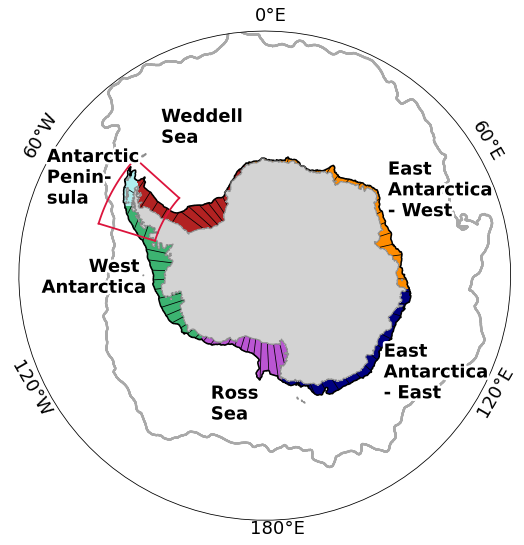

In [63]:
fig1 = plt.figure(constrained_layout=True, figsize=(9,9))
spec1 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig1)
axes = fig1.add_subplot(spec1[:, :], projection=ccrs.SouthPolarStereo(central_longitude=0))
subplot_labels = ['b)']
fig1.subplots_adjust(wspace = 0.05, hspace = 0)

# plot bounding circle and main figure features
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axes.set_extent([-280, 80, -80, -48], crs=ccrs.PlateCarree())
axes.set_boundary(circle, transform=axes.transAxes)
#axes.add_feature(land_50m, zorder=1, color='lightgrey')
axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=3,
                 colors='lightgrey', alpha=1, linewidths=1, transform = ccrs.PlateCarree())
axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
             colors='k', linewidths=1.5, zorder=3, transform = ccrs.PlateCarree())
axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=3,
             colors='grey', alpha=0.8, linewidths=1.2, transform = ccrs.PlateCarree())
axes.contour(Ncontour.xt_ocean, Ncontour.yt_ocean, Ncontour.sea_level_contour.squeeze(),  
               colors='darkgray', linewidths=2, linestyles='-', #green colour = '#33a02c'
               transform = ccrs.PlateCarree())
axes.pcolormesh(basin_mask.xu_ocean, basin_mask.yu_ocean, basin_mask.basins, 
              cmap=cmap_basins, zorder=2, vmin=1.5, vmax=8,
             transform = ccrs.PlateCarree())
add_basin_txt_stereo(axes, 'k', 'w')
add_lonlabels_stereo(axes, 'k', -48)

# plot release transects
arr = np.arange(-278, 82,5)
for i in range(len(arr)):
    if (i >= 41) and (i <=43):
        continue
    idx = np.where(ref.lon == arr[i])[0]
    minlat = ref.lat[idx].min()
    maxlat = ref.lat[idx].max()
    axes.plot((arr[i], arr[i]), (minlat, maxlat), color='k',lw=0.8,zorder=2,transform = ccrs.PlateCarree())
arr = [-71.5, -69.5, -67.5, -65.5, -63.5, -68, -66, -64]
for i in range(len(arr)):
    idx = np.where(ref.lat == arr[i])[0]
    minlon = ref.lon[idx].min()
    maxlon = ref.lon[idx].max()
    axes.plot((minlon, maxlon), (arr[i], arr[i]), color='k',lw=0.8,zorder=2,transform = ccrs.PlateCarree())

# plot bounding boxes for Weddell Sea
x,y = np.arange(-73, -47, 1), np.arange(-70, -59, 1)
x1 = np.full(len(y), -73)
x2 = np.full(len(y), -48)
y1 = np.full(len(x), -70)
y2 = np.full(len(x), -60)
c='crimson'
lw = 1.8
axes.plot(x, y1, c=c, linewidth=lw, linestyle = '-',zorder=4,
            transform = ccrs.PlateCarree())
axes.plot(x, y2, c=c, linewidth=lw, linestyle = '-',zorder=4,
            transform = ccrs.PlateCarree())
axes.plot(x1, y, c=c, linewidth=lw, linestyle = '-',zorder=4,
            transform = ccrs.PlateCarree())
axes.plot(x2, y, c=c, linewidth=lw, linestyle = '-',zorder=4,
            transform = ccrs.PlateCarree())
# Ross Sea
x = np.arange(-200, -159, 1)
y = np.arange(-77, -65.7, 0.1) 
x1 = np.full(len(y), -200)
x2 = np.full(len(y), -160)
y1 = np.full(len(x), -77)
y2 = np.full(len(x), -65.8)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures//for_publication/'
outfile = outdir + 'Figure03b_greycontour.png'
fig1.savefig(outfile, dpi=200, bbox_inches='tight')

# show figure
plt.show()

## Panel C

Subsample particle dataset for 500 Weddell Sea trajectory examples.

In [35]:
nparts = 500
ids = np.where(ref.lat[n:] == -69.5)[0]
ids = ids[ids<n]
arr = random.sample(list(ids), nparts)
tmplonWS = ds.lon[:,arr]
tmplonWS = tmplonWS.where(tmplonWS>-270)
tmplatWS = ds.lat[:,arr]
tmpshelfWS = ds.shelf[:,arr]

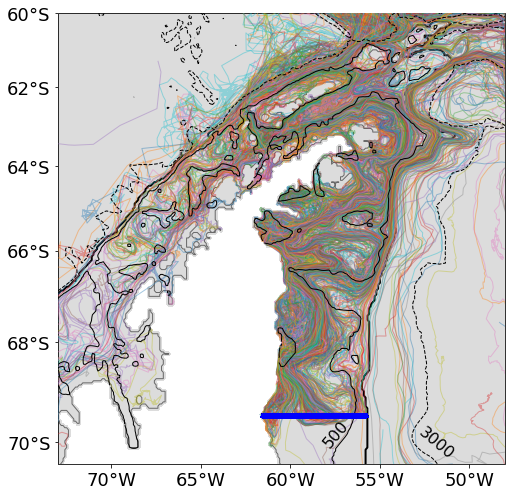

In [56]:
fig1 = plt.figure(constrained_layout=True, figsize=(7,7))
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)
ax1 = fig1.add_subplot(spec1[0,0], projection=ccrs.Mercator(central_longitude=260))
subplot_labels = ['a)', 'b)', 'c)','d)']


xticks = [-70, -65, -60, -55, -50,]
yticks = [-70, -68, -66, -64, -62, -60]
mercator_plot(ax1, [-73, -48, -70, -60], xticks, yticks)
ax1.tick_params(axis='x',labelsize=18)
ax1.tick_params(axis='y',labelsize=18)

bi = 0
ri = 0
li = 0
gi = 0
for i in range(500):
    ax1.plot(tmplonWS[:,i], tmplatWS[:,i], alpha=0.4, linewidth=1, zorder=3, transform = ccrs.PlateCarree())


ax1.contour(ht.xt_ocean, ht.yt_ocean, ht, [500], 
                 colors='k', linewidths=1, zorder=3, linestyles='-', transform = ccrs.PlateCarree())
cs = ax1.contour(ht.xt_ocean, ht.yt_ocean, ht, [3000], 
                 colors='k', linewidths=1, zorder=3, linestyles='--', transform = ccrs.PlateCarree())
ax1.text(-58.3, -70.1, "500", rotation=50, fontsize=16, c='k',  transform = ccrs.PlateCarree())
ax1.text(-53, -70.32, "3000", rotation=-40, fontsize=16, c='k',  transform = ccrs.PlateCarree())

for i in range(500):
    startid = np.where(np.isfinite(tmplonWS[:,i]))[0][0]
    ax1.scatter(tmplonWS[startid,:], tmplatWS[startid,:], marker='o', s=20, c = 'b',linestyle = 'dotted',zorder=4, transform = ccrs.PlateCarree())


#save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/figure01/'
outfile1 = outdir + 'Figure01d_trial_clabel_coloredlines.png'
outfile2 = outdir + 'Figure01d_trial_clabel.pdf'
fig1.savefig(outfile1, dpi=200, bbox_inches='tight')


plt.show()

**Figure 3c -zoom.**

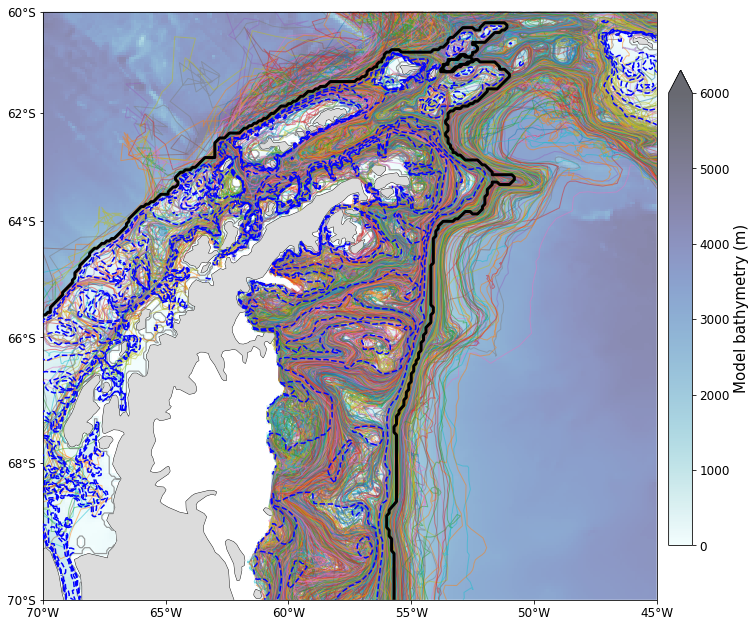

In [10]:
fig1 = plt.figure(constrained_layout=True, figsize=(11,11))
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)
f1_ax1 = fig1.add_subplot(spec1[0, 0],  projection=ccrs.Mercator(central_longitude=260))
fig1.subplots_adjust(wspace=0.01, hspace=0.01)
cmap_ht = cm.cm.ice_r#'Greys'

# axes 3: Mercator plot - WAP
f1_ax1.coastlines(resolution='50m')
f1_ax1.set_extent([-70, -48, -70, -60], crs=ccrs.PlateCarree())
f1_ax1.add_feature(land_50m, zorder=2, color='gainsboro')
f1_ax1.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], colors='k', alpha=1, linewidths=3, zorder=4, transform = ccrs.PlateCarree())
f1_ax1.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], colors='grey', alpha=0.8, linewidths=1.2, transform = ccrs.PlateCarree())
cb = f1_ax1.pcolormesh(ht.xt_ocean, ht.yt_ocean, ht, 
                       cmap=cmap_ht, vmin=0, vmax=6000, alpha=0.6, 
                       transform = ccrs.PlateCarree())
n = 130146
nparts = 1000
ids = np.where(ds_iv.basin[n:] == 12)[0]
ids = ids[ids<n]
arr = random.sample(list(ids), nparts)
tmplon = ds.lon[:,arr]
tmplon = tmplon.where(tmplon>-270)
tmplat = ds.lat[:,arr]
f1_ax1.plot(tmplon, tmplat, alpha=0.5, linewidth=1, transform = ccrs.PlateCarree())
f1_ax1.contour(pvor['xt_ocean'], pvor['yt_ocean'], pvor, zorder=4,
               levels = pv_lvls, colors='blue',linewidth=4, linestyle='-.',
               transform = ccrs.PlateCarree())
xticks = [-70, -65, -60, -55, -50, -45]
f1_ax1.set_xticks(xticks, crs=ccrs.PlateCarree())
yticks = [-70, -68, -66, -64, -62, -60]
f1_ax1.set_yticks(yticks, crs=ccrs.PlateCarree())
f1_ax1.xaxis.set_major_formatter(LongitudeFormatter())
f1_ax1.yaxis.set_major_formatter(LatitudeFormatter()) 
f1_ax1.tick_params(axis='x',labelsize=12)
f1_ax1.tick_params(axis='y',labelsize=12)

# Add a colorbar axis at right of figure
cbar_ax = fig1.add_axes([0.915, 0.2, 0.03, 0.6])
# Plot the colorbar
cbar=fig1.colorbar(cb, cax=cbar_ax,orientation='vertical', extend='max')
cbar.set_label('Model bathymetry (m)', fontsize=15)#, rotation=270)
cbar.ax.tick_params(labelsize=12)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/proj01/figures/'
outfile = outdir + 'Figure01b.jpg'
fig1.savefig(outfile, dpi=200, bbox_inches='tight')

plt.show()